# MCMC fitting of Miyamoto-Nagai profile to exponential LMC disk

In [1]:
import numpy as np
from modules import potential_tools as pt
import emcee
import os
from multiprocessing import Pool
import matplotlib.pyplot as plt
import getdist
from getdist import plots, loadMCSamples
import matplotlib as mpl

In [2]:
mpl.rcParams['axes.labelsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 'xx-large'
mpl.rcParams['ytick.labelsize'] = 'xx-large'

The idea is to fit the density derived from the Miyamoto-Nagai (MN) potential to an exponential disk. This would give the best fit MN profile to an exponential disk. We perform this fit using parallel MCMC sampling, using the emcee sampler. The MN density profile has three parameters: $a$ and $b$ are the radial and vertical scale lengths respectively. $logM$ is the logarithm of the mass which gets multiplied to the profile. Let the MN density be denoted as $\rho_{model}(R, z, a, b, logM)$. We have the actual density profile data of the exponential disk. Denote this by $\rho_{actual}(R_i, z_i)$. Denote the error on $\rho_{actual}(R_i, z_j)$ by $\sigma_{ij}$. We define the $\chi^2$ as:
\begin{equation}
\chi^2 = \sum_{ij} \left(\frac{\rho_{actual}(R_i, z_j) - \rho_{model}(R_i, z_j, a, b, logM)}{\sigma_{ij}}\right)^2
\end{equation}
We define the Likelihood function as:
\begin{equation}
L = e^{-\frac{\chi^2}{2}}
\end{equation}

## Obtaining the model densities

In [3]:
#Obtaining the R-z grid
R = np.load('./data/x_vals.npy')
z = np.load('./data/z_vals.npy')
Rgrid, zgrid = np.meshgrid(R, z)

In [4]:
def rho_model(params):
    a = params[0]
    b = params[1]
    logM = params[2]
    
    return pt.MN_rho(Rgrid, zgrid, a, b, logM).T

## Defining $\chi^2$

In [5]:
#Obtaning the actual densities
rho_actual = np.load('./data/2d_density.npy')
rho_actual_err = np.load('./data/error_2d_density.npy')

In [6]:
def chi2(params):
    return np.sum(np.divide(rho_actual - rho_model(params), rho_actual_err)**2)

## Defining likelihood

In [7]:
def ln_lkl(params):
    '''
    returns: log of the likelihood given parameters
    '''
    return -1*chi2(params)/2

## Defining priors

In [8]:
def flat_prior(params, prior_bounds):
    '''
    impose flat prior on params
    :params: array of parameters on which flat prior is required
    :prior_bounds: array of prior bounds. Shape (len(params), 2). First column is the lower bound and second
    column the upper bound
    returns: 0, if all the params are within the prior bounds
             -inf, if even one of the params is outside the prior bounds
    '''
    any_param_outside_bound = np.logical_or(bool(np.sum(params < prior_bounds[:,0])), 
                                            bool(np.sum(params > prior_bounds[:,1])))
    
    if any_param_outside_bound:
        return -np.inf
    else: 
        return 0

In [9]:
#Setting priors

a_prior_bounds = np.array([0.1, 5])
b_prior_bounds = np.array([0.1, 0.5])
logM_prior_bounds = np.array([9, 10])

prior_bounds = np.vstack([a_prior_bounds, b_prior_bounds, logM_prior_bounds])

In [10]:
def ln_prior(params):
    prior = flat_prior(params, prior_bounds = prior_bounds)
    return prior

## Defining the target distribution

In [11]:
def ln_target(params):
    '''
    target_distribution = likelihood * prior
    '''
    return ln_lkl(params) + ln_prior(params)

## Initializing the sampler

In [12]:
n_mcmc = 200 #chain length
n_walkers = 200 #number of parallel chains
sampling_dim = 3 #dimension of the parameter space

params0 = np.array([2, 0.3, 9.5]) #initial values for a, b and M

#Setting starting position of each chain

params_std = np.array([0.1, 0.025, 0.1]) #arbitrary
pos0 = params0[np.newaxis] + 3*params_std[np.newaxis]*np.random.normal(size = (n_walkers, sampling_dim))

In [13]:
#Setting number of parallel threads to use

os.environ["OMP_NUM_THREADS"] = "8"

## Sampling

In [14]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(n_walkers, sampling_dim, ln_target, pool = pool)
    sampler.run_mcmc(pos0, n_mcmc, progress = True)

  0%|                                                   | 0/200 [00:00<?, ?it/s]/home/himansh/anaconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████| 200/200 [00:01<00:00, 138.99it/s]


## Plotting the chains

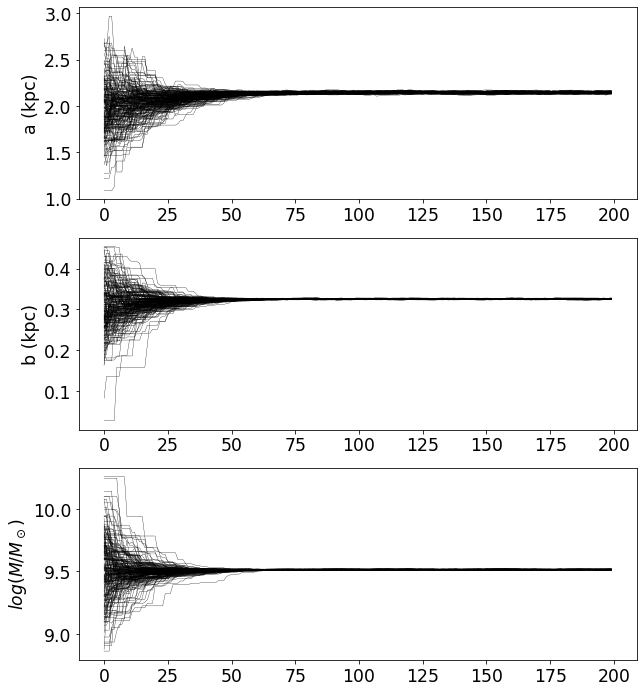

In [15]:
fig, ax = plt.subplots(sampling_dim, 1, figsize=(10, 12))
param_names = ['a (kpc)', 'b (kpc)', r'$log(M/M_\odot)$']
for i in range(sampling_dim):
    ax[i].plot(sampler.chain[:,:,i].T, 'k-', lw=0.3)
    ax[i].set_ylabel(param_names[i])
    
plt.savefig('./figures/MN_profile_chains.pdf', bbox_inches = 'tight')
plt.show()     

## Saving the chain

In [16]:
n_burnin = 50 #discard the first 50 points in each chain
n_thin = 2 #consider every alternate point in the chain

samples = sampler.chain[:, n_burnin::n_thin].reshape((-1, sampling_dim))

In [17]:
#np.savetxt('./chains/mcmc_MN_profile.txt', samples)